In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from pandas.plotting import scatter_matrix

ioTInTData = pd.read_csv("data/IoTID20/IoT_Network_Intrusion_Dataset_ToCombine.csv" , low_memory=False)
ioTInTData = ioTInTData[ioTInTData['Cat'] != 'Mirai']
ioTInTData = ioTInTData[ioTInTData['Cat'] != 'MITM ARP Spoofing']
ioTInTData = ioTInTData.iloc[:,:80]
print('ioTInTData', ioTInTData.shape)

#ioTInTData = ioTInTData.fillna(np.nan, inplace=True)
ioTInTData.replace([np.inf, -np.inf], np.nan, inplace=True)
ioTInTData.dropna(inplace=True)
ioTInTData.fillna(0)
ioTInTData.shape

def readDataSets():
    dataSetFridge = pd.read_csv(filepath_or_buffer = 'data/ToNIoT/cat/IoT_Fridge.csv')
    dataSetGarageDoor = pd.read_csv(filepath_or_buffer = 'data/ToNIoT/cat/IoT_Garage_Door.csv')
    dataSetGPS = pd.read_csv(filepath_or_buffer = 'data/ToNIoT/cat/IoT_GPS_Tracker.csv')
    dataSetModbus = pd.read_csv(filepath_or_buffer = 'data/ToNIoT/cat/IoT_Modbus.csv')
    dataSetMotionLight = pd.read_csv(filepath_or_buffer = 'data/ToNIoT/cat/IoT_Motion_Light.csv')
    dataSetThermostat = pd.read_csv(filepath_or_buffer = 'data/ToNIoT/cat/IoT_Thermostat.csv')
    dataSetWeahter = pd.read_csv(filepath_or_buffer = 'data/ToNIoT/cat/IoT_Weather.csv')

    dataSetFridge['temp_condition'] = dataSetFridge['temp_condition'].str.strip()
    dataSetGarageDoor['door_state'] = dataSetGarageDoor['door_state'].str.strip()
    dataSetMotionLight['light_status'] = dataSetMotionLight['light_status'].str.strip()
    dataSetRawLoad = pd.concat([dataSetFridge, dataSetGarageDoor, dataSetGPS, dataSetModbus, dataSetMotionLight, dataSetThermostat, dataSetWeahter])
    return dataSetRawLoad

In [ ]:
df = readDataSets()
df = df[df['type'] != 'backdoor']
df = df[df['type'] != 'password']
df = df[df['type'] != 'injection']
df = df[df['type'] != 'ransomware']
df = df[df['type'] != 'xss']
print(df.shape)

In [ ]:
df = df.rename(columns={"type": "Label"})
ioTInTData  = ioTInTData.drop(['Label'],axis=1) 
ioTInTData  = ioTInTData.rename(columns={"Cat": "Label"})

In [ ]:
# Load the data
categorical_features = ['door_state','sphone_signal', 'light_status','temp_condition']
quantitative_features = ['FC1_Read_Input_Register','FC2_Read_Discrete_Value','FC3_Read_Holding_Register','FC4_Read_Coil','current_temperature',
                        'fridge_temperature','humidity','latitude','FC4_Read_Coil','longitude',
                        'motion_status','pressure','temperature','thermostat_status']
features = categorical_features + quantitative_features


def datapreprocessingShuffle(data):
    scaler = StandardScaler()            
    # Feature scaling
    for i in data.columns:
        if(data[i].name !='Label'):
            data[i] = scaler.fit_transform(data[[i]])
        else:
            data[i]=data[i]
            
    data = shuffle(data).reset_index(drop=True) 
    return data


def datapreprocessingShuffle2(data):
               
    # Feature scaling
    for i in quantitative_features :
            scaler = StandardScaler()
            data[i] = scaler.fit_transform(data[[i]])
            
    # Encoding categorical features    
    for i in categorical_features :
        labelencoder=LabelEncoder()
        data[i]=labelencoder.fit_transform(data[i])   
    
    data = shuffle(data).reset_index(drop=True) 
    return data

In [ ]:
# Pre-processing datset
datacopy1 = ioTInTData.copy()
#datacopy1 = datacopy1.drop(['Cat'],axis=1) 
datacopy2 = df.copy()
datacopy1['Label'] = datacopy1.iloc[:,56:57].replace('DoS', '0').replace('Normal', '1').replace('Scan', '2').astype('int')
data1 = datapreprocessingShuffle(datacopy1)

data2 = datacopy2.rename(columns={"label": "Label"})
data2 = datapreprocessingShuffle2(data2) 
# fill na with mean for ToN_IoT dataset
data2 = data2.fillna(data2.mean())
print(data1.shape)
print(data2.shape)

In [27]:
data2['Label'] = data2.iloc[:,17:18].replace('ddos', '0').replace('normal', '1').replace('scanning', '2').astype('int')

In [28]:
# Pre-processing datset
datacopy1 = ioTInTData.copy()
datacopy2 = df.copy()
data1 = datapreprocessingShuffle(datacopy1)

data2 = datapreprocessingShuffle2(datacopy2) 
# fill na with mean for ToN_IoT dataset
data2 = data2.fillna(data2.mean())
print(data1.shape)
print(data2.shape)

In [36]:
print("data1: ddos", data1.loc[data2['Label'] == 0].shape)
print("data2: ddos", data2.loc[data2['Label'] == 0].shape)
print("data1: normal", data1.loc[data2['Label'] == 1].shape)
print("data2: normal", data2.loc[data2['Label'] == 1].shape)
print("data1: scan", data1.loc[data2['Label'] == 2].shape)
print("data2: scan", data2.loc[data2['Label'] == 2].shape)

(174729, 57)
(273973, 18)


data1: ddos (16068, 57)
data2: ddos (25000, 18)
data1: normal (156080, 57)
data2: normal (245000, 18)
data1: scan (2581, 57)
data2: scan (3973, 18)


# Data 1 Training

In [63]:
#0:59391 | gan0: 59391
#-------------
#0:25000 | gan1: 25000 data2
#-------------
#1:40073 | gan0: 40073
#-------------
#1:245000  | gan1: 245000 data2
#-------------
#2:75265 | gan0: 75265
#-------------
#2:3973  | gan1: 3973 data2

#ganData = data2.loc[data2['Label'] == 0] #Dos

#ganData = data1.loc[data1['Label'] == 0] #Dos

#ganData = data2.loc[data2['Label'] == 1] #normal

#ganData = data1.loc[data1['Label'] == 1] #normal

#ganData = data2.loc[data2['Label'] == 2] #scan

ganData = data1.loc[data1['Label'] == 2] #scan


import GAN_171103
import importlib
importlib.reload(GAN_171103) # For reloading after making changes
from GAN_171103 import *


 # 32 # needs to be ~data_dim
base_n_count = 128 # 128

nb_steps = 500 + 1 # 50000 # Add one for logging of the last interval
batch_size = 128 # 64

k_d = 1  # number of critic network updates per adversarial training step
k_g = 1  # number of generator network updates per adversarial training step
critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
learning_rate = 5e-4 # 5e-5
data_dir = 'cache/'
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

# show = False
show = True 

# train = create_toy_spiral_df(1000)
# train = create_toy_df(n=1000,n_dim=2,n_classes=4,seed=0)
train = ganData.copy().reset_index(drop=True) # fraud only with labels from classification


# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'Label' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]


rand_dim = len(data_cols)

In [ ]:
%%time

# Training the vanilla GAN and CGAN architectures

k_d = 1  # number of critic network updates per adversarial training step
learning_rate = 5e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_GAN(arguments, train_no_label, data_cols ) # GAN
#adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # CGAN

data_dim:  56
data_cols:  ['Protocol', 'Flow_Duration', 'Tot_Fwd_Pkts', 'Tot_Bwd_Pkts', 'TotLen_Fwd_Pkts', 'TotLen_Bwd_Pkts', 'Fwd_Pkt_Len_Max', 'Fwd_Pkt_Len_Min', 'Fwd_Pkt_Len_Mean', 'Fwd_Pkt_Len_Std', 'Bwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Min', 'Bwd_Pkt_Len_Mean', 'Bwd_Pkt_Len_Std', 'Flow_Byts/s', 'Flow_Pkts/s', 'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min', 'Fwd_IAT_Tot', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Min', 'Bwd_IAT_Tot', 'Bwd_IAT_Mean', 'Bwd_IAT_Std', 'Bwd_IAT_Min', 'Bwd_PSH_Flags', 'Bwd_URG_Flags', 'Fwd_Header_Len', 'Bwd_Header_Len', 'Fwd_Pkts/s', 'Bwd_Pkts/s', 'Pkt_Len_Min', 'Pkt_Len_Max', 'Pkt_Len_Mean', 'Pkt_Len_Std', 'Pkt_Len_Var', 'FIN_Flag_Cnt', 'SYN_Flag_Cnt', 'RST_Flag_Cnt', 'ACK_Flag_Cnt', 'URG_Flag_Cnt', 'CWE_Flag_Count', 'ECE_Flag_Cnt', 'Down/Up_Ratio', 'Fwd_Seg_Size_Avg', 'Init_Bwd_Win_Byts', 'Fwd_Act_Data_Pkts', 'Active_Mean', 'Active_Std', 'Active_Min', 'Idle_Mean', 'Idle_Std', 'Idle_Min']
Model: "generator"
_____________________________________

D:\SoftwareInstalled\lib\site-packages\tensorflow\python\keras\backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Step: 0 of 501.
Losses: G, D Gen, D Real, Xgb: 0.7165, 0.7197, 0.6986, 1.0000
D Real - D Gen: -0.0211


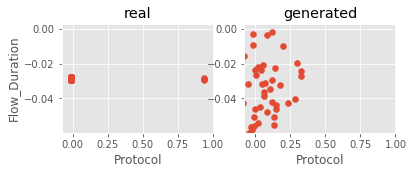

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 1.6373, 0.4042, 0.5254, 0.9980
D Real - D Gen: 0.1211


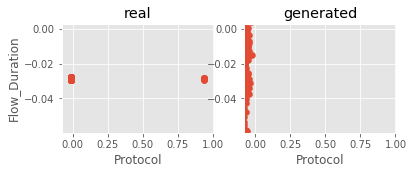

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 1.5617, 0.3853, 0.4612, 0.9959
D Real - D Gen: 0.0759


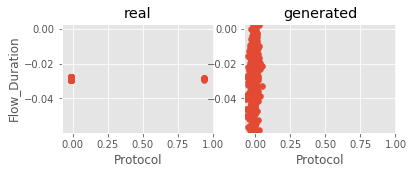

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 1.5652, 0.4022, 0.5342, 0.9959
D Real - D Gen: 0.1320


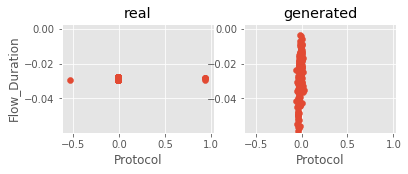

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 1.6381, 0.3972, 0.5278, 0.9959
D Real - D Gen: 0.1307


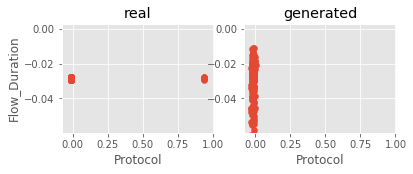

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 1.4915, 0.5149, 0.4537, 1.0000
D Real - D Gen: -0.0612


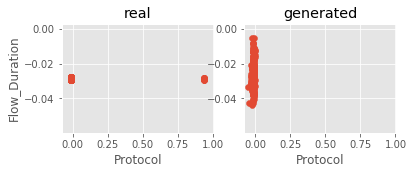

Wall time: 1min 14s


In [ ]:
seed = 17

train = ganData.copy().reset_index(drop=True) # fraud only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ train.columns[-1]  ]
data_cols = [ i for i in train.columns if i not in label_cols ]
#train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim = len(data_cols)
label_dim = len(label_cols)
#if label_dim > 0: with_class = True
np.random.seed(seed)

# define network models

generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count)
generator_model.load_weights('cache/GAN_generator_model_weights_step_500.h5')


# Now generate some new data
test_size = len(train) # Equal to all of the fraud cases

x = get_data_batch(train_no_label, test_size, seed=3)
z = np.random.normal(size=(test_size, rand_dim))
g_z = generator_model.predict(z)

 

# =============================================================================
# check data
# =============================================================================
df2=pd.DataFrame(np.rint(np.abs(g_z)),columns=ganData.columns[:-1])
df2=df2.astype(int)



def define_models_GAN(rand_dim, data_dim, base_n_count, type=None):
    generator_input_tensor = layers.Input(shape=(rand_dim, ))
    generated_image_tensor = generator_network(generator_input_tensor, data_dim, base_n_count)

    generated_or_real_image_tensor = layers.Input(shape=(data_dim,))
    
    if type == 'Wasserstein':
        discriminator_output = critic_network(generated_or_real_image_tensor, data_dim, base_n_count)
    else:
        discriminator_output = discriminator_network(generated_or_real_image_tensor, data_dim, base_n_count)

    generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')
    discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
                                       outputs=[discriminator_output],
                                       name='discriminator')

    combined_output = discriminator_model(generator_model(generator_input_tensor))
    combined_model = models.Model(inputs=[generator_input_tensor], outputs=[combined_output], name='combined')
    
    return generator_model, discriminator_model, combined_model

def generate_data_gan(n_samples,Xdf,path_model,rand_dim=32):
    generator_model, discriminator_model, combined_model= define_models_GAN(rand_dim,data_dim=len(Xdf.columns),base_n_count=128)
    generator_model.load_weights(path_model)
    z = np.random.normal(size=(n_samples, rand_dim))
    g_z = generator_model.predict(z)
    
    newdf = pd.DataFrame()
    for i, col in enumerate(Xdf.columns):

        if Xdf[col].dtype == 'int32' or Xdf[col].dtype == 'int64':
            newdf[col] = np.rint(np.abs(g_z[:,i])).astype(int)    
        elif Xdf[col].dtype == 'float_':
            newdf[col] = np.abs(g_z[:,i]) 
    return newdf



#data2 = 401119
#data1 = 119698

#data1 Attack (92172)          | data2 GAN attack (~170033)
#------------------------------|------------------
#data1 GAN Attack (~156119)    | data2 attack (156119)
#------------------------------|------------------
#data1 No Attack (27526)       | data2 GAN No attack (~40073)
#------------------------------|------------------
#data1 GAN No Attack (~245000) | data2 No attack (245000)
#170033
n_samples=2581 

# data2 True
#n_samples=45485


Xdf=ganData.iloc[:,:-1]    
path_model='cache/GAN_generator_model_weights_step_500.h5'

#Attack0G0=generate_data_gan(n_samples,Xdf,path_model,rand_dim=len(data_cols))  
#Attack0G0.shape

#Attack0G1=generate_data_gan(n_samples,Xdf,path_model,rand_dim=len(data_cols))  
#Attack0G1.shape

#Attack1G0=generate_data_gan(n_samples,Xdf,path_model,rand_dim=len(data_cols))  
#Attack1G0.shape

#Attack1G1=generate_data_gan(n_samples,Xdf,path_model,rand_dim=len(data_cols))  
#Attack1G1.shape

#Attack2G0=generate_data_gan(n_samples,Xdf,path_model,rand_dim=len(data_cols))  
#Attack2G0.shape

Attack2G1=generate_data_gan(n_samples,Xdf,path_model,rand_dim=len(data_cols))  
Attack2G1.shape

(2581, 56)

In [ ]:
#row1
tData1Dos = data1.loc[data1['Label'] == 0] 
tData1Dos = tData1Dos.iloc[:,:-1]
tData1Dos = tData1Dos.reset_index(drop=True)
row1A = pd.concat([tData1Dos, Attack0G0], axis = 1).reset_index(drop=True)
row1A.shape

#row2
tData2Dos = data2.loc[data2['Label'] == 0] 
tData2Dos = tData2Dos.iloc[:,:-1]
tData2Dos = tData2Dos.reset_index(drop=True)
row2A = pd.concat([Attack0G1, tData2Dos], axis = 1).reset_index(drop=True)
row2A.shape

#row3
tData1Normal = data1.loc[data1['Label'] == 1] 
tData1Normal = tData1Normal.iloc[:,:-1]
tData1Normal = tData1Normal.reset_index(drop=True)
row3A = pd.concat([tData1Normal, Attack1G0], axis = 1).reset_index(drop=True)
row3A.shape

#row4
tData2Normal = data2.loc[data2['Label'] == 1] 
tData2Normal = tData2Normal.iloc[:,:-1]
tData2Normal = tData2Normal.reset_index(drop=True)
row4A = pd.concat([Attack1G1, tData2Normal], axis = 1).reset_index(drop=True)
row4A.shape

#row5
tData1Scan = data1.loc[data1['Label'] == 2] 
tData1Scan = tData1Scan.iloc[:,:-1]
tData1Scan = tData1Scan.reset_index(drop=True)
row5A = pd.concat([tData1Scan, Attack2G0], axis = 1).reset_index(drop=True)
row5A.shape

#row6
tData2Scan = data2.loc[data2['Label'] == 2] 
tData2Scan = tData2Scan.iloc[:,:-1]
tData2Scan = tData2Scan.reset_index(drop=True)
row6A = pd.concat([Attack2G1, tData2Scan], axis = 1).reset_index(drop=True)
row6A.shape

In [ ]:
rowDos = row2A.append(row1A) #.append(row3A).append(row4A)
rowDos['Label'] = '0'
rowDos.shape

In [ ]:
rowNormal = row3A.append(row4A) #.append(row3A).append(row4A)
rowNormal['Label'] = '1'
rowNormal.shape

In [ ]:
rowScan = row5A.append(row6A) #.append(row3A).append(row4A)
rowScan['Label'] = '2'
rowScan.shape

In [ ]:
fData = rowDos.append(rowNormal).append(rowScan)
fData.shape

(79238, 74)

(653629, 74)

In [ ]:
#matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
carrier_count = fData['Label'].value_counts()
sns.set(style="darkgrid")
sns.barplot(carrier_count.index, carrier_count.values, alpha=0.9)
plt.title('Frequency Distribution of Cat')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Cat', fontsize=12)
plt.show()

In [ ]:
fData.replace([np.inf, -np.inf], np.nan, inplace=True)
fData.dropna(inplace=True)
fData.fillna(0)
fData.shape

In [ ]:
pd.DataFrame(fData['Label'].value_counts())[:]

In [ ]:
ff =  fData[fData['Label'] == '2']
df1 = ff.copy()
df2 = ff.copy()
df3 = ff.copy()
df4 = ff.copy()
df5 = ff.copy()
dfm = pd.concat([ff, df1, df2, df3, df4, df5]).sample(frac=1).reset_index(drop=True)
dfm.shape

In [85]:
def cutSize(df):
    newdf1 = df[df['Label'] == '0'].iloc[0:30000,:]
    newdf2 = df[df['Label'] == '1'].iloc[0:30000,:]
    n = pd.concat([newdf1, newdf2]).sample(frac=1).reset_index(drop=True)
    return n

(30972, 74)

In [ ]:
ff2 = cutSize(fData)
fData1 = pd.concat([ff, ff2]).sample(frac=1).reset_index(drop=True)
fData1.shape

In [ ]:
fData1.to_csv('Ganned-cat-merged.csv', index=False)

In [ ]:
fData1['Label'] = fData1['Label'].astype('int')

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score,plot_confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from statistics import mean 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor 
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
import time
from sklearn.model_selection import RepeatedStratifiedKFold



# This method will give the max value item in list
def my_max_by_weight(sequence):
    if not sequence:
        raise ValueError('empty sequence')
    maximum = sequence[0]
    for item in sequence:
        if item[0] > maximum[0]:
            maximum = item
    return maximum



# This will give the classification results using Logistic Regression model
def LogisticRegressionAccuracy(X_train, X_test, y_train, y_test):
    # create a variable for the range from 1 to 100
    cS = np.linspace(1, 100, 100, endpoint=True, dtype= int)
    # properties initialization
    train_results = []
    test_results = []
    cValueList = []
    # loop that applied range on the model one by one and return a list of accuracies with C value for hyper parameter
    for c in cS:
        dt = LogisticRegression(C=c, random_state=0)
        dt.fit(X_train,y_train)
        pred_result = dt.predict(X_test)
        score2 = dt.score(X_test, y_test)
        cValueList.append([score2, c])
    # using C that has most accuracy in the range in the list
    dt = LogisticRegression(C=my_max_by_weight(cValueList)[1], random_state=0)
    # fit the train and test
    dt.fit(X_train, y_train)
    # plot confusion matrix 
    plot_confusion_matrix(dt, X_test, y_test)
    plt.show()
    y_pred = dt.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='weighted')
    recall = recall_score(y_test,y_pred, average='weighted')
    score = f1_score(y_test, y_pred, average='weighted')
    resultObj = {"precision":precision,"recall":recall,"f1score":score,"accuracy":accuracy,"cm":cm}
    return resultObj


# This will give the classification results using KNeighbors  model
def KNeighborsAccuracy(X_train, X_test, y_train, y_test):
    # create a variable for the range from 1 to 100
    n_neighbors = np.linspace(1, 100, 50, endpoint=True, dtype= int)
    # object of train and testing arrays from TFIDF vectorizer
    # properties initialization
    train_results = []
    test_results = []
    cValueList = []
    # loop that applied range on the model one by one and return a list of accuracies with n_neighbors value for hyper parameter
    for n_neighbor in n_neighbors:
        dt = KNeighborsClassifier(n_neighbors=n_neighbor,metric='minkowski',p=2)
        dt.fit(X_train,y_train)
        pred_result = dt.predict(X_test)
        score2 = dt.score(X_test, y_test)
        cValueList.append([score2, n_neighbor])
    # using n_neighbors that has most accuracy in the range in the list
    dt = KNeighborsClassifier(n_neighbors=my_max_by_weight(cValueList)[1],metric='minkowski',p=2)
    # fit the train and test
    dt.fit(X_train, y_train)
    # plot confusion matrix 
    plot_confusion_matrix(dt, X_test, y_test)
    plt.show()
    y_pred = dt.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='weighted')
    recall = recall_score(y_test,y_pred, average='weighted')
    score = f1_score(y_test, y_pred, average='weighted')
    resultObj = {"precision":precision,"recall":recall,"f1score":score,"accuracy":accuracy,"cm":cm}
    return resultObj

# This will give the classification results using Logistic Regression model
def DTAccuracy(X_train, X_test, y_train, y_test):
    # create a variable for the range from 1 to 100
    max_depths = np.linspace(1, 100, 100, endpoint=True, dtype= int)
    # properties initialization
    train_results = []
    test_results = []
    cValueList = []
    # loop that applied range on the model one by one and return a list of accuracies with C value for hyper parameter
    for max_depth in max_depths:
        dt = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
        dt.fit(X_train,y_train)
        pred_result = dt.predict(X_test)
        score2 = dt.score(X_test, y_test)
        cValueList.append([score2, max_depth])
    # using C that has most accuracy in the range in the list
    dt = DecisionTreeClassifier(max_depth=my_max_by_weight(cValueList)[1], random_state=0)
    # fit the train and test
    dt.fit(X_train, y_train)
    # plot confusion matrix 
    plot_confusion_matrix(dt, X_test, y_test)
    plt.show()
    y_pred = dt.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='weighted')
    recall = recall_score(y_test,y_pred, average='weighted')
    score = f1_score(y_test, y_pred, average='weighted')
    resultObj = {"precision":precision,"recall":recall,"f1score":score,"accuracy":accuracy,"cm":cm}
    return resultObj


# This will give the classification results using Logistic Regression model
def RFAccuracy(X_train, X_test, y_train, y_test):
    # create a variable for the range from 1 to 100
    max_depths = np.linspace(1, 100, 100, endpoint=True, dtype= int)
    # properties initialization
    train_results = []
    test_results = []
    cValueList = []
    # loop that applied range on the model one by one and return a list of accuracies with C value for hyper parameter
    for max_depth in max_depths:
        dt = RandomForestClassifier(max_depth=max_depth, random_state=0)
        dt.fit(X_train,y_train)
        pred_result = dt.predict(X_test)
        score2 = dt.score(X_test, y_test)
        cValueList.append([score2, max_depth])
    # using C that has most accuracy in the range in the list
    dt = RandomForestClassifier(max_depth=my_max_by_weight(cValueList)[1], random_state=0)
    # fit the train and test
    dt.fit(X_train, y_train)
    # plot confusion matrix 
    plot_confusion_matrix(dt, X_test, y_test)
    plt.show()
    y_pred = dt.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='weighted')
    recall = recall_score(y_test,y_pred, average='weighted')
    score = f1_score(y_test, y_pred, average='weighted')
    resultObj = {"precision":precision,"recall":recall,"f1score":score,"accuracy":accuracy,"cm":cm}
    return resultObj

def GBAccuracy(X_train, X_test, y_train, y_test):
    # create a variable for the range from 1 to 100
    max_depths = np.linspace(100, 120, 10, endpoint=True, dtype= int)
    # properties initialization
    train_results = []
    test_results = []
    cValueList = []
    # loop that applied range on the model one by one and return a list of accuracies with C value for hyper parameter
    for max_depth in max_depths:
        dt = GradientBoostingClassifier(n_estimators=max_depth)
        dt.fit(X_train,y_train)
        pred_result = dt.predict(X_test)
        score2 = dt.score(X_test, y_test)
        cValueList.append([score2, max_depth])
    # using C that has most accuracy in the range in the list
    dt = GradientBoostingClassifier(n_estimators=my_max_by_weight(cValueList)[1])
    # fit the train and test
    dt.fit(X_train, y_train)
    # plot confusion matrix 
    plot_confusion_matrix(dt, X_test, y_test)
    plt.show()
    y_pred = dt.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='weighted')
    recall = recall_score(y_test,y_pred, average='weighted')
    score = f1_score(y_test, y_pred, average='weighted')
    resultObj = {"precision":precision,"recall":recall,"f1score":score,"accuracy":accuracy,"cm":cm}
    return resultObj

def NBAccuracy(X_train, X_test, y_train, y_test):
    # create a variable for the range from 1 to 100
    max_depths = np.logspace(0,-9, num=10)
    # properties initialization
    train_results = []
    test_results = []
    cValueList = []
    # loop that applied range on the model one by one and return a list of accuracies with C value for hyper parameter
    for max_depth in max_depths:
        dt = GaussianNB(var_smoothing=max_depth)
        dt.fit(X_train,y_train)
        pred_result = dt.predict(X_test)
        score2 = dt.score(X_test, y_test)
        cValueList.append([score2, max_depth])
    # using C that has most accuracy in the range in the list
    dt = GaussianNB(var_smoothing=my_max_by_weight(cValueList)[1])
    # fit the train and test
    dt.fit(X_train, y_train)
    # plot confusion matrix 
    plot_confusion_matrix(dt, X_test, y_test)
    plt.show()
    y_pred = dt.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='weighted')
    recall = recall_score(y_test,y_pred, average='weighted')
    score = f1_score(y_test, y_pred, average='weighted')
    resultObj = {"precision":precision,"recall":recall,"f1score":score,"accuracy":accuracy,"cm":cm}
    return resultObj





# This will give the classification results using Logistic Regression model
def AdaBoostClassifierAccuracy(X_train, X_test, y_train, y_test):
    # create a variable for the range from 1 to 100
    #max_depths = np.linspace(1, 10, 10, endpoint=True, dtype= int)
    n_trees = [10, 50, 100, 500, 1000, 5000]
    # properties initialization
    train_results = []
    test_results = []
    cValueList = []
    # loop that applied range on the model one by one and return a list of accuracies with C value for hyper parameter
    for n in n_trees:
        dt = AdaBoostClassifier(n_estimators=n,learning_rate=1)
        dt.fit(X_train,y_train)
        pred_result = dt.predict(X_test)
        score2 = dt.score(X_test, y_test)
        cValueList.append([score2, n])
    # using C that has most accuracy in the range in the list
    dt = AdaBoostClassifier(n_estimators=my_max_by_weight(cValueList)[1])
    # fit the train and test
    dt.fit(X_train, y_train)
    # plot confusion matrix 
    plot_confusion_matrix(dt, X_test, y_test)
    plt.show()
    y_pred = dt.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='weighted')
    recall = recall_score(y_test,y_pred, average='weighted')
    score = f1_score(y_test, y_pred, average='weighted')
    resultObj = {"precision":precision,"recall":recall,"f1score":score,"accuracy":accuracy,"cm":cm}
    return resultObj

# This will give the classification results using Logistic Regression model
def XGBClassifierAccuracy(X_train, X_test, y_train, y_test):
    # create a variable for the range from 1 to 100
    max_depths =np.linspace(1, 100, 100, endpoint=True, dtype= int)
    # properties initialization
    train_results = []
    test_results = []
    cValueList = []
    # loop that applied range on the model one by one and return a list of accuracies with C value for hyper parameter
    for max_depth in max_depths:
        dt = XGBClassifier(max_depth=max_depth, max_delta_step=0)
        dt.fit(X_train,y_train)
        pred_result = dt.predict(X_test)
        score2 = dt.score(X_test, y_test)
        cValueList.append([score2, max_depth])
    # using C that has most accuracy in the range in the list
    dt = XGBClassifier(max_depth=my_max_by_weight(cValueList)[1], max_delta_step=0)
    # fit the train and test
    dt.fit(X_train, y_train)
    # plot confusion matrix 
    plot_confusion_matrix(dt, X_test, y_test)
    plt.show()
    y_pred = dt.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='weighted')
    recall = recall_score(y_test,y_pred, average='weighted')
    score = f1_score(y_test, y_pred, average='weighted')
    resultObj = {"precision":precision,"recall":recall,"f1score":score,"accuracy":accuracy,"cm":cm}
    return resultObj

# This will give the classification results using Logistic Regression model
def SVCAccuracy(X_train, X_test, y_train, y_test):
    # create a variable for the range from 1 to 100
    cS = np.linspace(1, 100, 100, endpoint=True, dtype= int)
    # properties initialization
    train_results = []
    test_results = []
    cValueList = []
    # loop that applied range on the model one by one and return a list of accuracies with C value for hyper parameter
    for c in cS:
        dt = SVC(C = c , kernel="rbf",random_state=0)
        dt.fit(X_train,y_train)
        pred_result = dt.predict(X_test)
        score2 = dt.score(X_test, y_test)
        cValueList.append([score2, c])
    # using C that has most accuracy in the range in the list
    dt = SVC(C=my_max_by_weight(cValueList)[1], kernel="rbf",random_state=0)
    # fit the train and test
    dt.fit(X_train, y_train)
    # plot confusion matrix 
    plot_confusion_matrix(dt, X_test, y_test)
    plt.show()
    y_pred = dt.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='weighted')
    recall = recall_score(y_test,y_pred, average='weighted')
    score = f1_score(y_test, y_pred, average='weighted')
    resultObj = {"precision":precision,"recall":recall,"f1score":score,"accuracy":accuracy,"cm":cm}
    return resultObj

# This will give the classification results using Logistic Regression model
def LDAAccuracy(X_train, X_test, y_train, y_test):
    # create a variable for the range from 1 to 100
    cS = ['svd', 'lsqr', 'eigen']
    # properties initialization
    train_results = []
    test_results = []
    cValueList = []
    # loop that applied range on the model one by one and return a list of accuracies with C value for hyper parameter
    for c in cS:
        dt = LinearDiscriminantAnalysis(solver = c)
        dt.fit(X_train,y_train)
        pred_result = dt.predict(X_test)
        score2 = dt.score(X_test, y_test)
        cValueList.append([score2, c])
    # using C that has most accuracy in the range in the list
    dt = LinearDiscriminantAnalysis(solver=my_max_by_weight(cValueList)[1])
    # fit the train and test
    dt.fit(X_train, y_train)
    # plot confusion matrix 
    plot_confusion_matrix(dt, X_test, y_test)
    plt.show()
    y_pred = dt.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='weighted')
    recall = recall_score(y_test,y_pred, average='weighted')
    score = f1_score(y_test, y_pred, average='weighted')
    resultObj = {"precision":precision,"recall":recall,"f1score":score,"accuracy":accuracy}
    return resultObj


In [ ]:
data1y = data1['Label']
data1X = data1.drop(['Label'],axis=1)

X_s = select_featuresPCA(X, y, len(data1X.columns))


dt = DTAccuracy(X_s, data1X, y, data1y)
print("DT",dt)
rf = RFAccuracy(X_s, data1X, y, data1y)
print("RF", rf)
nb = NBAccuracy(X_s, data1X, y, data1y)
print("nb", nb)
lda = LDAAccuracy(X_s, data1X, y, data1y)
print("LDA", lda)
lr = LogisticRegressionAccuracy(X_s, data1X, y, data1y)
print("LR", lr)
knn = KNeighborsAccuracy(X_s, data1X, y, data1y)
print("KNN", knn)
svm = SVCAccuracy(X_s, data1X, y, data1y)
print("SVM", svm)
ada = AdaBoostClassifierAccuracy(X_s, data1X, y, data1y)
print("ADA", ada)
xgb = XGBClassifierAccuracy(X_s, data1X.values, y, data1y)
print("XGB", xgb)
gb = GBAccuracy(X_s, data1X, y, data1y)
print("GB", gb)

In [91]:
print(pd.DataFrame(data2['Label'].value_counts())[:])
print(pd.DataFrame(data1['Label'].value_counts())[:])

In [ ]:
fData = shuffle(fData).reset_index(drop=True)
onlyNormal = fData.loc[fData['Label'] == 1].iloc[0:100000,:]
restOf = fData.loc[fData['Label'] != 1]
newfData = pd.concat([onlyNormal, restOf])
pd.DataFrame(newfData['Label'].value_counts())[:]

In [ ]:
data2.to_csv('data2.csv', index=False)

In [ ]:
newData2 = pd.read_csv("data2.csv" , low_memory=False)
newData2 = newData2.reset_index(drop=True) 

In [107]:
newData1 = data1.iloc[0:80000,:]
print(pd.DataFrame(newData2['Label'].value_counts())[:])
print(pd.DataFrame(newData1['Label'].value_counts())[:])

In [110]:
y = fData1['Label'].astype('int')
X = fData1.drop(['Label'],axis=1) 

print(y.shape)
print(X.shape)

from sklearn.preprocessing import MinMaxScaler
# on this distribution. 
sc = MinMaxScaler()
X_std =  sc.fit_transform(X)

cov_matrix = np.cov(X_std.T)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
# Make a set of (eigenvalue, eigenvector) pairs:
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]
# Sort the (eigenvalue, eigenvector) pairs from highest to lowest with respect to eigenvalue
#eig_pairs.sort()
eig_pairs.reverse()
#print(eig_pairs)
# Extract the descending ordered eigenvalues and eigenvectors
eigvalues_sorted = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sorted = [eig_pairs[index][1] for index in range(len(eigenvalues))]
# Let's confirm our sorting worked, print out eigenvalues
#print('Eigenvalues in descending order: \n%s' %eigvalues_sorted)

tot = sum(eigenvalues)
var_explained = [(i / tot) for i in sorted(eigenvalues, reverse=True)]  # an array of variance explained by each 
# eigen vector... there will be 18 entries as there are 18 eigen vectors)
cum_var_exp = np.cumsum(var_explained)  # an array of cumulative variance. There will be 18 entries with 18 th entry 
# cumulative reaching almost 100%

plt.bar(range(1,74), var_explained, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,74),cum_var_exp, where= 'mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.show()

In [93]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA

# feature selection
def select_featuresMutual(X, y):
    fs = SelectKBest(score_func=mutual_info_classif, k=4)
    X_new = fs.fit_transform(X, y)
    return X_new

# feature selection
def select_featuresPCA(X, y, n_comp):
    fs = PCA(n_components=n_comp)
    X_new = fs.fit_transform(X, y)
    return X_new

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score,plot_confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from statistics import mean 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score



# This method will give the max value item in list
def my_max_by_weight(sequence):
    if not sequence:
        raise ValueError('empty sequence')
    maximum = sequence[0]
    for item in sequence:
        if item[0] > maximum[0]:
            maximum = item
    return maximum


# This will give the classification results using Logistic Regression model
def DTAccuracy(X_train, X_test, y_train, y_test):
    # create a variable for the range from 1 to 100
    max_depths = np.linspace(1, 10, 10, endpoint=True, dtype= int)
    # properties initialization
    train_results = []
    test_results = []
    cValueList = []
    # loop that applied range on the model one by one and return a list of accuracies with C value for hyper parameter
    for max_depth in max_depths:
        dt = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
        dt.fit(X_train,y_train)
        pred_result = dt.predict(X_test)
        score2 = dt.score(X_test, y_test)
        cValueList.append([score2, max_depth])
    # using C that has most accuracy in the range in the list
    dt = DecisionTreeClassifier(max_depth=my_max_by_weight(cValueList)[1], random_state=0)
    # fit the train and test
    dt.fit(X_train, y_train)
    # plot confusion matrix 
    plot_confusion_matrix(dt, X_test, y_test)
    plt.show()
    y_pred = dt.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='micro')
    recall = recall_score(y_test,y_pred, average='micro')
    score = f1_score(y_test, y_pred, average='micro')
    report = metrics.classification_report(y_test, y_pred, target_names=['0', '1', '2'])
    resultObj = {"precision":precision,"recall":recall,"f1score":score,"accuracy":accuracy,"cm":cm, "report": report}
    return resultObj


# This will give the classification results using Logistic Regression model
def RFAccuracy(X_train, X_test, y_train, y_test):
    # create a variable for the range from 1 to 100
    max_depths = np.linspace(1, 10, 10, endpoint=True, dtype= int)
    # properties initialization
    train_results = []
    test_results = []
    cValueList = []
    # loop that applied range on the model one by one and return a list of accuracies with C value for hyper parameter
    for max_depth in max_depths:
        dt = RandomForestClassifier(max_depth=max_depth, random_state=0)
        dt.fit(X_train,y_train)
        pred_result = dt.predict(X_test)
        score2 = dt.score(X_test, y_test)
        cValueList.append([score2, max_depth])
    # using C that has most accuracy in the range in the list
    dt = RandomForestClassifier(max_depth=my_max_by_weight(cValueList)[1], random_state=0)
    # fit the train and test
    dt.fit(X_train, y_train)
    # plot confusion matrix 
    plot_confusion_matrix(dt, X_test, y_test)
    plt.show()
    y_pred = dt.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='micro')
    recall = recall_score(y_test,y_pred, average='micro')
    score = f1_score(y_test, y_pred, average='micro')
    report = metrics.classification_report(y_test, y_pred, target_names=['0', '1', '2'])
    resultObj = {"precision":precision,"recall":recall,"f1score":score,"accuracy":accuracy,"cm":cm, "report": report}
    return resultObj

def GBAccuracy(X_train, X_test, y_train, y_test):
    # create a variable for the range from 1 to 100
    max_depths = np.linspace(100, 120, 10, endpoint=True, dtype= int)
    # properties initialization
    train_results = []
    test_results = []
    cValueList = []
    # loop that applied range on the model one by one and return a list of accuracies with C value for hyper parameter
    for max_depth in max_depths:
        dt = GradientBoostingClassifier(n_estimators=max_depth)
        dt.fit(X_train,y_train)
        pred_result = dt.predict(X_test)
        score2 = dt.score(X_test, y_test)
        cValueList.append([score2, max_depth])
    # using C that has most accuracy in the range in the list
    dt = GradientBoostingClassifier(n_estimators=my_max_by_weight(cValueList)[1])
    # fit the train and test
    dt.fit(X_train, y_train)
    # plot confusion matrix 
    plot_confusion_matrix(dt, X_test, y_test)
    plt.show()
    y_pred = dt.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='micro')
    recall = recall_score(y_test,y_pred, average='micro')
    score = f1_score(y_test, y_pred, average='micro')
    report = metrics.classification_report(y_test, y_pred, target_names=['0', '1', '2'])
    resultObj = {"precision":precision,"recall":recall,"f1score":score,"accuracy":accuracy,"cm":cm, "report": report}
    return resultObj

def NBAccuracy(X_train, X_test, y_train, y_test):
    # create a variable for the range from 1 to 100
    max_depths = np.logspace(0,-9, num=10)
    # properties initialization
    train_results = []
    test_results = []
    cValueList = []
    # loop that applied range on the model one by one and return a list of accuracies with C value for hyper parameter
    for max_depth in max_depths:
        dt = GaussianNB(var_smoothing=max_depth)
        dt.fit(X_train,y_train)
        pred_result = dt.predict(X_test)
        score2 = dt.score(X_test, y_test)
        cValueList.append([score2, max_depth])
    # using C that has most accuracy in the range in the list
    dt = GaussianNB(var_smoothing=my_max_by_weight(cValueList)[1])
    # fit the train and test
    dt.fit(X_train, y_train)
    # plot confusion matrix 
    plot_confusion_matrix(dt, X_test, y_test)
    plt.show()
    y_pred = dt.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='micro')
    recall = recall_score(y_test,y_pred, average='micro')
    score = f1_score(y_test, y_pred, average='micro')
    report = metrics.classification_report(y_test, y_pred, target_names=['0', '1', '2'])
    resultObj = {"precision":precision,"recall":recall,"f1score":score,"accuracy":accuracy,"cm":cm, "report": report}
    return resultObj

# This will give the classification results using Logistic Regression model
def LogisticRegressionAccuracy(X_train, X_test, y_train, y_test):
    # create a variable for the range from 1 to 100
    cS = np.linspace(1, 10, 10, endpoint=True, dtype= int)
    # properties initialization
    train_results = []
    test_results = []
    cValueList = []
    # loop that applied range on the model one by one and return a list of accuracies with C value for hyper parameter
    for c in cS:
        dt = LogisticRegression(C=c, random_state=0)
        dt.fit(X_train,y_train)
        pred_result = dt.predict(X_test)
        score2 = dt.score(X_test, y_test)
        cValueList.append([score2, c])
    # using C that has most accuracy in the range in the list
    dt = LogisticRegression(C=my_max_by_weight(cValueList)[1], random_state=0)
    # fit the train and test
    dt.fit(X_train, y_train)
    # plot confusion matrix 
    plot_confusion_matrix(dt, X_test, y_test)
    plt.show()
    y_pred = dt.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='micro')
    recall = recall_score(y_test,y_pred, average='micro')
    score = f1_score(y_test, y_pred, average='micro')
    report = metrics.classification_report(y_test, y_pred, target_names=['0', '1', '2'])
    resultObj = {"precision":precision,"recall":recall,"f1score":score,"accuracy":accuracy,"cm":cm, "report": report}
    return resultObj

# This will give the classification results using KNeighbors  model
def KNeighborsAccuracy(X_train, X_test, y_train, y_test):
    # create a variable for the range from 1 to 100
    n_neighbors = np.linspace(1, 10, 10, endpoint=True, dtype= int)
    # object of train and testing arrays from TFIDF vectorizer
    # properties initialization
    train_results = []
    test_results = []
    cValueList = []
    # loop that applied range on the model one by one and return a list of accuracies with n_neighbors value for hyper parameter
    for n_neighbor in n_neighbors:
        dt = KNeighborsClassifier(n_neighbors=n_neighbor,metric='minkowski',p=2)
        dt.fit(X_train,y_train)
        pred_result = dt.predict(X_test)
        score2 = dt.score(X_test, y_test)
        cValueList.append([score2, n_neighbor])
    # using n_neighbors that has most accuracy in the range in the list
    dt = KNeighborsClassifier(n_neighbors=my_max_by_weight(cValueList)[1],metric='minkowski',p=2)
    # fit the train and test
    dt.fit(X_train, y_train)
    # plot confusion matrix 
    plot_confusion_matrix(dt, X_test, y_test)
    plt.show()
    y_pred = dt.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='micro')
    recall = recall_score(y_test,y_pred, average='micro')
    score = f1_score(y_test, y_pred, average='micro')
    report = metrics.classification_report(y_test, y_pred, target_names=['0', '1', '2'])
    resultObj = {"precision":precision,"recall":recall,"f1score":score,"accuracy":accuracy,"cm":cm, "report": report}
    return resultObj

# This will give the classification results using Logistic Regression model
def AdaBoostClassifierAccuracy(X_train, X_test, y_train, y_test):
    # create a variable for the range from 1 to 100
    #max_depths = np.linspace(1, 10, 10, endpoint=True, dtype= int)
    n_trees = [10, 50, 100, 500, 1000, 5000]
    # properties initialization
    train_results = []
    test_results = []
    cValueList = []
    # loop that applied range on the model one by one and return a list of accuracies with C value for hyper parameter
    for n in n_trees:
        dt = AdaBoostClassifier(n_estimators=n,learning_rate=1)
        dt.fit(X_train,y_train)
        pred_result = dt.predict(X_test)
        score2 = dt.score(X_test, y_test)
        cValueList.append([score2, n])
    # using C that has most accuracy in the range in the list
    dt = AdaBoostClassifier(n_estimators=my_max_by_weight(cValueList)[1])
    # fit the train and test
    dt.fit(X_train, y_train)
    # plot confusion matrix 
    plot_confusion_matrix(dt, X_test, y_test)
    plt.show()
    y_pred = dt.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='micro')
    recall = recall_score(y_test,y_pred, average='micro')
    score = f1_score(y_test, y_pred, average='micro')
    report = metrics.classification_report(y_test, y_pred, target_names=['0', '1', '2'])
    resultObj = {"precision":precision,"recall":recall,"f1score":score,"accuracy":accuracy,"cm":cm, "report": report}
    return resultObj

# This will give the classification results using Logistic Regression model
def XGBClassifierAccuracy(X_train, X_test, y_train, y_test):
    # create a variable for the range from 1 to 100
    max_depths = np.linspace(1, 10, 10, endpoint=True, dtype= int)
    # properties initialization
    train_results = []
    test_results = []
    cValueList = []
    # loop that applied range on the model one by one and return a list of accuracies with C value for hyper parameter
    for max_depth in max_depths:
        dt = XGBClassifier(max_depth=max_depth, max_delta_step=0)
        dt.fit(X_train,y_train)
        pred_result = dt.predict(X_test)
        score2 = dt.score(X_test, y_test)
        cValueList.append([score2, max_depth])
    # using C that has most accuracy in the range in the list
    dt = XGBClassifier(max_depth=my_max_by_weight(cValueList)[1], max_delta_step=0)
    # fit the train and test
    dt.fit(X_train, y_train)
    # plot confusion matrix 
    plot_confusion_matrix(dt, X_test, y_test)
    plt.show()
    y_pred = dt.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='micro')
    recall = recall_score(y_test,y_pred, average='micro')
    score = f1_score(y_test, y_pred, average='micro')
    report = metrics.classification_report(y_test, y_pred, target_names=['0', '1', '2'])
    resultObj = {"precision":precision,"recall":recall,"f1score":score,"accuracy":accuracy,"cm":cm, "report": report}
    return resultObj

# This will give the classification results using Logistic Regression model
def SVCAccuracy(X_train, X_test, y_train, y_test):
    # create a variable for the range from 1 to 100
    cS = np.linspace(1, 10, 10, endpoint=True, dtype= int)
    # properties initialization
    train_results = []
    test_results = []
    cValueList = []
    # loop that applied range on the model one by one and return a list of accuracies with C value for hyper parameter
    for c in cS:
        dt = SVC(C = c , kernel="rbf",random_state=0)
        dt.fit(X_train,y_train)
        pred_result = dt.predict(X_test)
        score2 = dt.score(X_test, y_test)
        cValueList.append([score2, c])
    # using C that has most accuracy in the range in the list
    dt = SVC(C=my_max_by_weight(cValueList)[1], kernel="rbf",random_state=0)
    # fit the train and test
    dt.fit(X_train, y_train)
    # plot confusion matrix 
    plot_confusion_matrix(dt, X_test, y_test)
    plt.show()
    y_pred = dt.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='micro')
    recall = recall_score(y_test,y_pred, average='micro')
    score = f1_score(y_test, y_pred, average='micro')
    report = metrics.classification_report(y_test, y_pred, target_names=['0', '1', '2'])
    resultObj = {"precision":precision,"recall":recall,"f1score":score,"accuracy":accuracy,"cm":cm, "report": report}
    return resultObj

def SoftVotingAccuracy(X_train, X_test, y_train, y_test):
    # create a variable for the range from 1 to 100
    models = list()
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeRegressor()))
    models.append(('NB', GaussianNB()))
    models.append(('MLP', MLPClassifier()))
    models.append(('DT', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('LR', LogisticRegression()))
    models.append(('SVM', svm.SVC()))
    models.append(('AdaBoost', AdaBoostClassifier()))
    models.append(('GradientBoosting', GradientBoostingClassifier()))
    models.append(('XGB', XGBClassifier()))
    # properties initialization
    train_results = []
    test_results = []
    cValueList = []
    # loop that applied range on the model one by one and return a list of accuracies with C value for hyper parameter
    for c in models:
        dt = VotingClassifier(estimators=c, voting='soft')
        dt.fit(X_train,y_train)
        pred_result = dt.predict(X_test)
        score2 = dt.score(X_test, y_test)
        cValueList.append([score2, c])
    # using C that has most accuracy in the range in the list
    dt = VotingClassifier(estimators=my_max_by_weight(cValueList)[1], voting='soft')
    # fit the train and test
    dt.fit(X_train, y_train)
    # plot confusion matrix 
    plot_confusion_matrix(dt, X_test, y_test)
    plt.show()
    y_pred = dt.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    score = f1_score(y_test, y_pred)
    resultObj = {"precision":precision,"recall":recall,"f1score":score,"accuracy":accuracy,"cm":cm}
    return resultObj

In [102]:
data1y = newData1['Label']
data1X = newData1.drop(['Label'],axis=1)

X_s = select_featuresPCA(X, y, len(data1X.columns))


dt = DTAccuracy(X_s, data1X, y, data1y)
print("DT",dt)
rf = RFAccuracy(X_s, data1X, y, data1y)
print("RF", rf)
nb = NBAccuracy(X_s, data1X, y, data1y)
print("nb", nb)
lr = LogisticRegressionAccuracy(X_s, data1X, y, data1y)
print("LR", lr)
knn = KNeighborsAccuracy(X_s, data1X, y, data1y)
print("KNN", knn)
svm = SVCAccuracy(X_s, data1X, y, data1y)
print("SVM", svm)
ada = AdaBoostClassifierAccuracy(X_s, data1X, y, data1y)
print("ADA", ada)
xgb = XGBClassifierAccuracy(X_s, data1X.values, y, data1y)
print("XGB", xgb)
gb = GBAccuracy(X_s, data1X, y, data1y)
print("GB", gb)
sv = SoftVotingAccuracy(X_s, data1X, y, data1y)
print("gb", sv)

In [ ]:
data2y = newData2['Label']
data2X = newData2.drop(['Label'],axis=1)
X2_s = select_featuresPCA(X, y, len(data2X.columns))


dt2 = DTAccuracy(X2_s, data2X, y, data2y)
print("DT",dt2)
rf2 = RFAccuracy(X2_s, data2X, y, data2y)
print("RF", rf2)
nb2 = NBAccuracy(X2_s, data2X, y, data2y)
print("RF", nb2)
lr2 = LogisticRegressionAccuracy(X2_s, data2X, y, data2y)
print("LR", lr2)
knn2 = KNeighborsAccuracy(X2_s, data2X, y, data2y)
print("KNN", knn2)
svm2 = SVCAccuracy(X2_s, data2X, y, data2y)
print("SVM", svm2)
ada2 = AdaBoostClassifierAccuracy(X2_s, data2X, y, data2y)
print("ADA", ada2)
xgb2 = XGBClassifierAccuracy(X2_s, data2X.values, y, data2y)
print("XGB", xgb2)
gb2 = GBAccuracy(X2_s, data2X, y, data2y)
print("GB", gb2)
sv = SoftVotingAccuracy(X2_s, data2X, y, data2y)
print("gb", sv)